In [2]:
import os
import json
import pandas as pd
import configparser
from snowflake.snowpark import Session
from copy import copy
from snowflake.snowpark import Row
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path, udf
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException
from snowflake.snowpark.files import SnowflakeFile

# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('credentials.cfg')

# Create a Python dictionary (dict) containing the names and values of the parameters for connecting to Snowflake.
#connection_parameters = dict(
#   account   =  config['SNOWPARKAZ']['SNOWFLAKE_ACCOUNT'],
#   user      =  config['SNOWPARKAZ']['SNOWFLAKE_USER'],
#   password  =  config['SNOWPARKAZ']['SNOWFLAKE_PASSWORD'],
#   role      =  config['SNOWPARKAZ']['SNOWFLAKE_ROLE'],  # optional
#   warehouse =  config['SNOWPARKAZ']['SNOWFLAKE_WAREHOUSE'],  # optional
#   database  =  config['SNOWPARKAZ']['SNOWFLAKE_DATABASE'],  # optional
#   schema    =  config['SNOWPARKAZ']['SNOWFLAKE_SCHEMA'],  # optional
#)

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  config['SNOWPARKAWS']['SNOWFLAKE_ROLE'],  # optional
   warehouse =  config['SNOWPARKAWS']['SNOWFLAKE_WAREHOUSE'],  # optional
   database  =  config['SNOWPARKAWS']['SNOWFLAKE_DATABASE'],  # optional
   schema    =  config['SNOWPARKAWS']['SNOWFLAKE_SCHEMA'],  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

### `Creating User-Defined Functions (UDFs) for DataFrames in Python`

- Snowpark API Reference (Python): https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/index

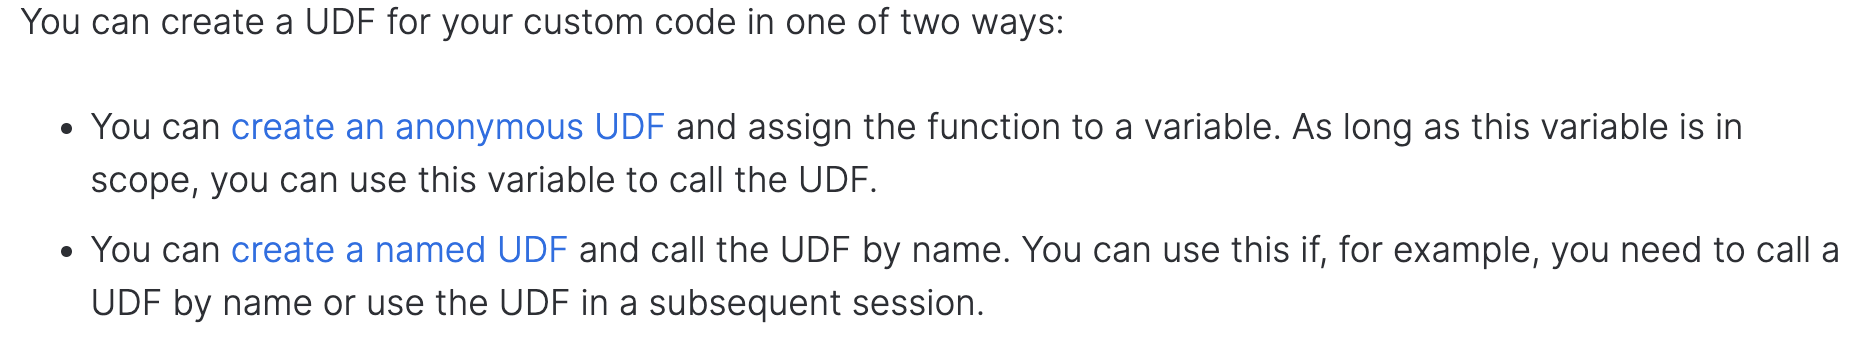

#### `Creating an Anonymous UDF`

- To create an anonymous UDF, you can either:
 - Call the `udf` function in the `snowflake.snowpark.functions` module, passing in the definition of the anonymous function.
 - Call the `register` method in the `UDFRegistration` class, passing in the definition of the anonymous function.

In [3]:
from snowflake.snowpark.types import IntegerType
from snowflake.snowpark.functions import udf

add_one = udf(lambda x:x+1, return_type=IntegerType(), input_types=[IntegerType()])

#### `Creating and Registering a Named UDF`

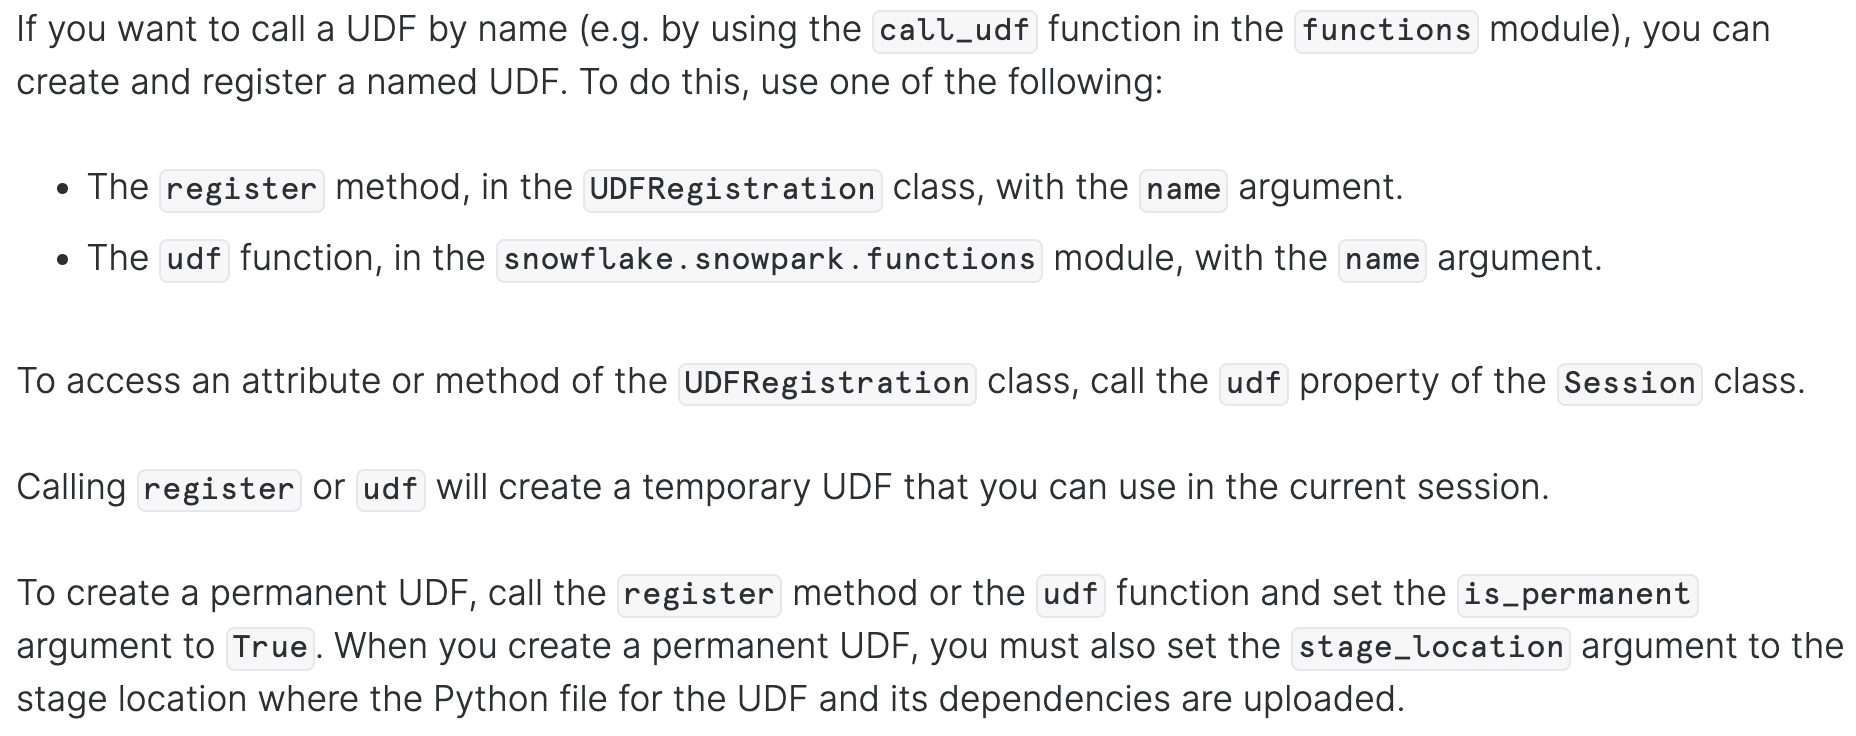

In [4]:
# Here is an example of how to register a named temporary UDF:
add_one = udf(lambda x:x+1, return_type=IntegerType(), input_types=[IntegerType()], name="my_udf", replace=True)

In [5]:
# Option-1
# Here is an example of how to register a named permanent UDF by setting the is_permanent argument to True:
add_one = udf(lambda x:x+1, return_type=IntegerType(), input_types=[IntegerType()], name="add_one", replace=True, is_permanent=True, stage_location="@SF_UDF_INT_STG")

In [6]:
# Option-2
# Here is an example of how to register a named permanent UDF by setting the is_permanent argument to True:
@udf(name="minus_one", is_permanent=True, stage_location="@SF_UDF_INT_STG", replace=True)
def minus_one(x: int) -> int:
    return x - 1

In [11]:
# Here is an example of these UDFs being called:
df = session.create_dataframe([[1,2],[3,4]]).to_df("a","b")
df.select(add_one("a"), minus_one("b")).show()

-----------------------------------------
|"ADD_ONE(""A"")"  |"MINUS_ONE(""B"")"  |
-----------------------------------------
|4                 |3                   |
|2                 |1                   |
-----------------------------------------



In [12]:
# You can also call the UDF using SQL:
session.sql("select add_one(1)").show()

----------------
|"ADD_ONE(1)"  |
----------------
|2             |
----------------



#### `Creating a UDF from a Python source file`

In [ ]:
# Here are examples of using register_from_file.
# Suppose you have a Python file test_udf_file.py that contains:
#def mod5(x: int) -> int:
#    return x % 5

In [14]:
#Option-1: Then you can create a UDF from this function of file test_udf_file.py

# mod5() in the file has type hints
mod5_udf = session.udf.register_from_file(
    file_path="test_udf_file.py",
    func_name="mod5",
)

In [16]:
df_range = session.range(1,10,2).to_df("a")
df_range.select(col("a"), mod5_udf("a")).show()

------------------------------------------------------------
|"A"  |"""SNOWPARK_DB"".""PUBLIC"".SNOWPARK_TEMP_FUNCT...  |
------------------------------------------------------------
|7    |2                                                   |
|9    |4                                                   |
|1    |1                                                   |
|3    |3                                                   |
|5    |0                                                   |
------------------------------------------------------------



- https://docs.snowflake.com/en/sql-reference/sql/put

In [17]:
# Upload local file into internal stage (sf_int_stg) 
session.sql("put file://test_udf_file.py @sf_int_stg/ AUTO_COMPRESS=FALSE OVERWRITE = TRUE").collect()

[Row(source='test_udf_file.py', target='test_udf_file.py', source_size=41, target_size=48, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [19]:
# List internal stage files
session.sql("ls @sf_int_stg/").show()

----------------------------------------------------------------------------------------------------------
|"name"                       |"size"  |"md5"                             |"last_modified"               |
----------------------------------------------------------------------------------------------------------
|sf_int_stg/car_sales.json    |848     |d69652cd0d10f4651db31c180bd8dff6  |Fri, 8 Dec 2023 17:25:35 GMT  |
|sf_int_stg/car_sales1.json   |656     |04c4262b096991965a9887a75393ef8d  |Sat, 9 Dec 2023 00:59:33 GMT  |
|sf_int_stg/data1.csv         |32      |ba2e510d1d6a424a5b0da2be426dad7f  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/data1.json        |80      |1a1c422f98f927bb42fdcdecab72faae  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/sales.json        |320     |6019c0d9cef2959d7e6cd54ce6319904  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/test_udf_file.py  |48      |5ccc824fece95f654836a6f862415576  |Sat, 9 Dec 2023 02:40:59 GMT  |
-------------------------------------

In [21]:
# Option-2: You can also upload the file to a stage location, then use it to create the UDF
from snowflake.snowpark.types import IntegerType

# Suppose you have uploaded test_udf_file.py to stage location sf_int_stg
mod5_udf =  session.udf.register_from_file(file_path='@sf_int_stg/test_udf_file.py'
                                           ,func_name='mod5'
                                           ,return_type=IntegerType()
                                           ,input_types=[IntegerType()]
                                          )

In [22]:
df_range = session.range(1,10,2).to_df("a")
df_range.select(col("a"), mod5_udf("a")).show()

------------------------------------------------------------
|"A"  |"""SNOWPARK_DB"".""PUBLIC"".SNOWPARK_TEMP_FUNCT...  |
------------------------------------------------------------
|1    |1                                                   |
|3    |3                                                   |
|7    |2                                                   |
|5    |0                                                   |
|9    |4                                                   |
------------------------------------------------------------



#### `Reading Files with a UDF`

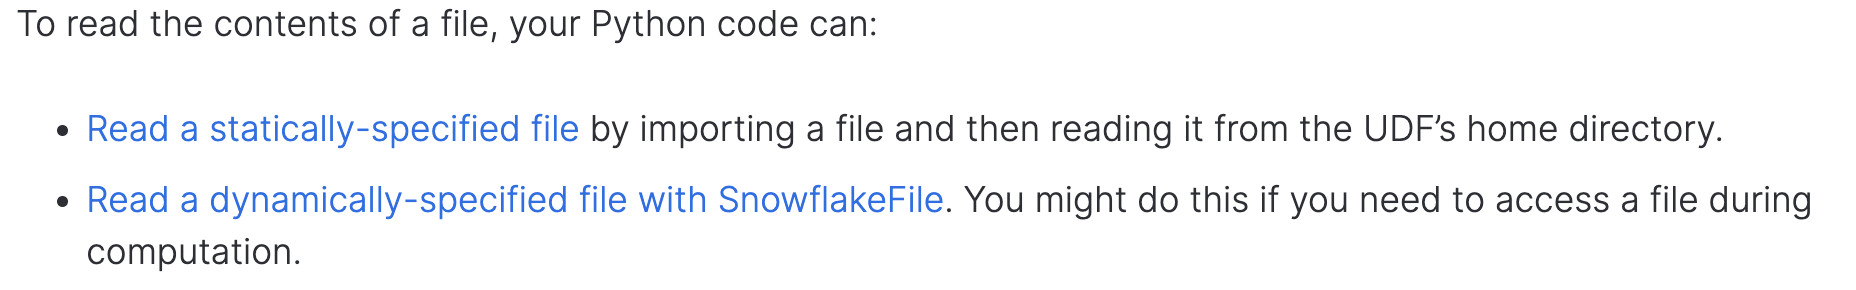

`Reading Statically-Specified Files`

In [ ]:
# Import a file from your local machine as a dependency.
session.add_import("/<path>/my_file.txt")  

# Or import a file that you uploaded to a stage as a dependency.
session.add_import("@my_stage/<path>/my_file.txt")  

In [ ]:
import sys
import os
import cachetools
from snowflake.snowpark.types import StringType
@cachetools.cached(cache={})
def read_file(filename):
    import_dir = sys._xoptions.get("snowflake_import_directory")
    if import_dir:
        with open(os.path.join(import_dir, filename), "r") as f:
            return f.read()
        
# create a temporary text file for test
temp_file_name = "/tmp/temp.txt"
with open(temp_file_name, "w") as t:
    _ = t.write("snowpark")
session.add_import(temp_file_name)
session.add_packages("cachetools")

def add_suffix(s):
    return f"{read_file(os.path.basename(temp_file_name))}-{s}"

concat_file_content_with_str_udf = session.udf.register(
    add_suffix,
    return_type=StringType(),
    input_types=[StringType()]
)

df = session.create_dataframe(["snowflake", "python"], schema=["a"])
df.select(concat_file_content_with_str_udf("a")).to_df("col1").collect()
#[Row(COL1='snowpark-snowflake'), Row(COL1='snowpark-python')]
os.remove(temp_file_name)
session.clear_imports()

`Reading Dynamically-Specified Files with SnowflakeFile`

`You can read a file from a stage using the `SnowflakeFile` class in the `Snowpark snowflake.snowpark.files` module. The `SnowflakeFile` class provides dynamic file access, which lets you stream files of any size.`

- Python UDF Handler Examples: https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-examples#label-reading-file-from-python-udf-snowflakefile

In [23]:
# The following example registers a temporary UDF that reads a text file from a stage using SnowflakeFile and returns the file length.

# Step1: Register the UDF:
from snowflake.snowpark.functions import udf
from snowflake.snowpark.files import SnowflakeFile
from snowflake.snowpark.types import StringType, IntegerType

@udf(name="get_file_length", replace=True, input_types=[StringType()], return_type=IntegerType(), packages=['snowflake-snowpark-python'])
def get_file_length(file_path):
    with SnowflakeFile.open(file_path) as f:
        s = f.read()
    return len(s)

- BUILD_SCOPED_FILE_URL: https://docs.snowflake.com/en/sql-reference/functions/build_scoped_file_url

In [25]:
# Call the UDF:
# BUILD_SCOPED_FILE_URL( @<stage_name> , '<relative_file_path>' )
session.sql("select get_file_length(build_scoped_file_url(@sf_int_stg, 'car_sales1.json'))").show()

------------------------------------------------------
|"GET_FILE_LENGTH(BUILD_SCOPED_FILE_URL(@SF_INT_...  |
------------------------------------------------------
|648                                                 |
------------------------------------------------------



#### `Using Vectorized UDFs`

- https://docs.snowflake.com/en/developer-guide/snowpark/python/creating-udfs

In [ ]:
# TBD

In [26]:
# Closing a Session
session.close()